In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy
import pandas as pd
import cmocean as cmo
from cartopy.util import add_cyclic_point

In [2]:
green = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/lgm/ref_files/CAM4-CAM5_Greens_Function.nc')

In [18]:
## ANNUAL files
lgmDA_lgm_ann_ATM = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/lgm/lgmDA_lgm_ATM_annual_v2.1.nc')
lgmDA_hol_ann_ATM = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/lgm/lgmDA_hol_ATM_annual_v2.1.nc')

lgmDA_lgm_ann = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/lgm/lgmDA_lgm_Ocn_annual_v2.1.nc')
lgmDA_hol_ann = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/lgm/lgmDA_hol_Ocn_annual_v2.1.nc')
lgmDA_lgm_ann = lgmDA_lgm_ann.set_coords(('lat','lon'))
lgmDA_hol_ann = lgmDA_hol_ann.set_coords(('lat','lon'))

In [4]:
## MONTHLY files
lgmDA_lgm_mon = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/lgm/lgmDA_lgm_SST_monthly_climo.nc')
lgmDA_hol_mon = xr.open_dataset('/home/disk/atmos/vcooper/work/p2c2/lgm/lgmDA_hol_SST_monthly_climo_v2.1.nc')

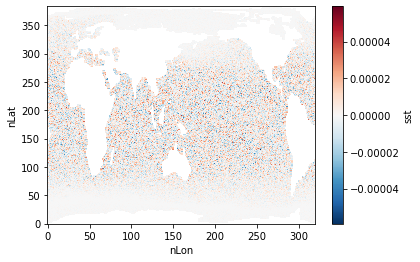

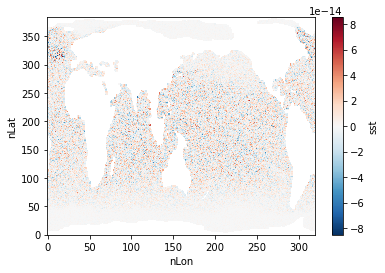

In [9]:
(lgmDA_hol_ann.sst - lgmDA_hol_mon.sst.mean(axis=0)).plot()
plt.show()
(lgmDA_lgm_ann.sst - lgmDA_lgm_mon.sst.mean(axis=0)).plot()
plt.show()

In [10]:
## use existing bc as target grid

newgrid = green #xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(green.TOA_CAM4 == 0,0,1)

data_for_regridding = lgmDA_lgm_ann
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         filename='bilinear_again2.nc',
                         reuse_weights=True)
regridder

lgmDA_lgm_ann_regrid = regridder(lgmDA_lgm_ann.sst)
lgmDA_hol_ann_regrid = regridder(lgmDA_hol_ann.sst)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


In [11]:
lgmDA_lgm_mon_regrid = regridder(lgmDA_lgm_mon.sst)
lgmDA_hol_mon_regrid = regridder(lgmDA_hol_mon.sst)

In [15]:
dT = lgmDA_lgm_ann_regrid - lgmDA_hol_ann_regrid
dTmon = (lgmDA_lgm_mon_regrid - lgmDA_hol_mon_regrid).mean(axis=0)

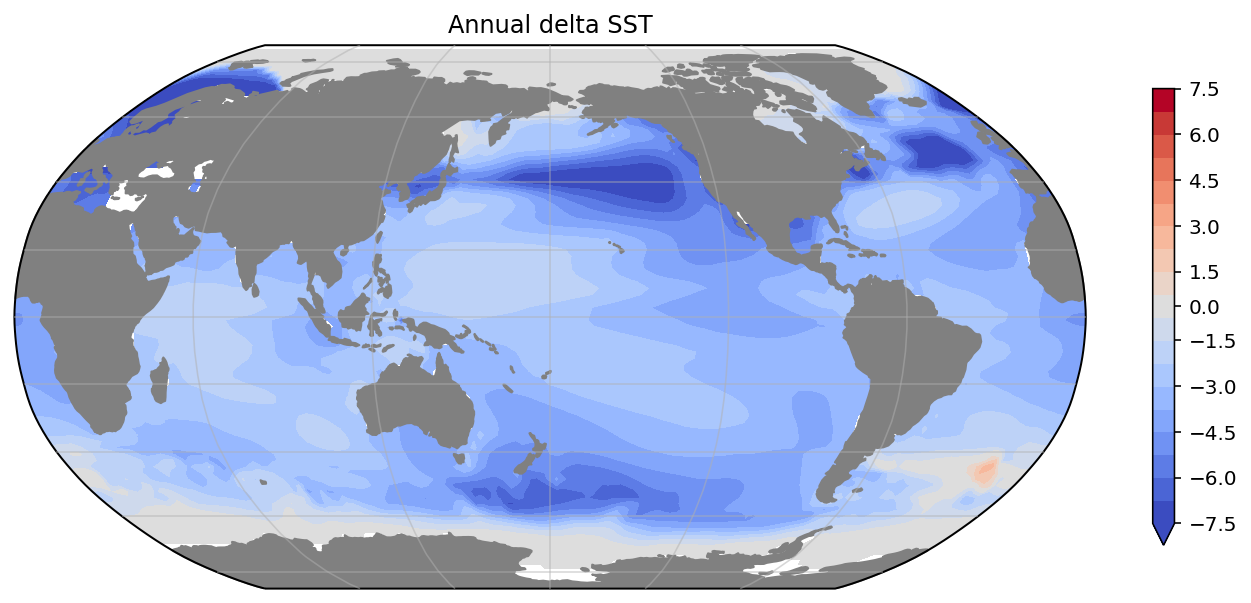

In [13]:
nlevs = 10*2 ## must be even
vabs = 7.5
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('coolwarm', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = dT
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,1.5))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Annual delta SST')
plt.show()

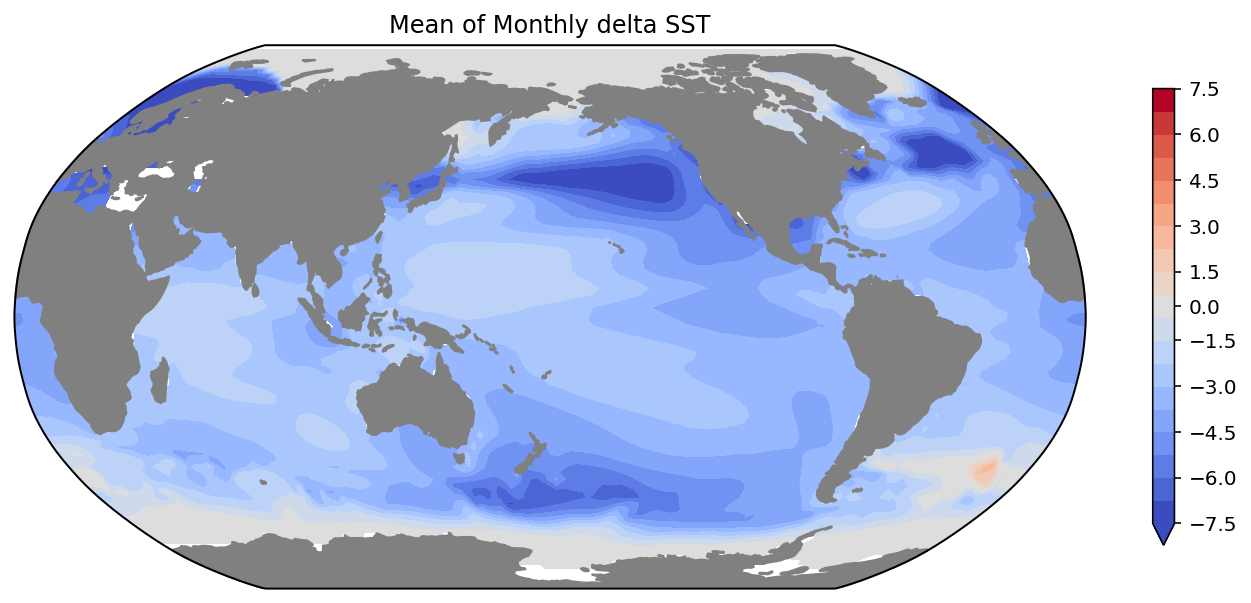

In [16]:
nlevs = 10*2 ## must be even
vabs = 7.5
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('coolwarm', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = dTmon
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,1.5))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.title('Mean of Monthly delta SST')
plt.show()

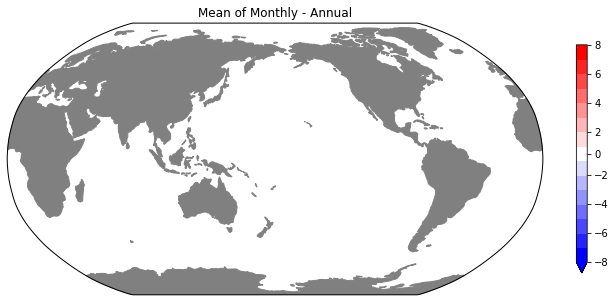

In [17]:
nlevs = 8*2 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = dTmon-dT
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
plt.title('Mean of Monthly - Annual')
plt.show()

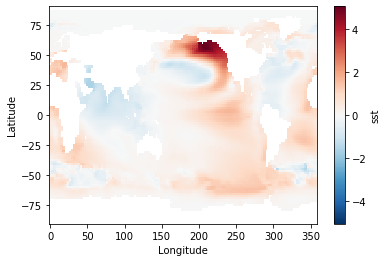

In [39]:
(dTmon2 - dT).plot()

In [27]:
((dTmon * green.TOA_CAM4).sum(axis=(1,2)) / (dTmon * green.TAS_CAM4).sum(axis=(1,2))).mean()

<xarray.DataArray ()>
array(-2.55439865)

In [33]:
print('monthly\n', (dTmon2 * green.TOA_CAM4).sum() / (dTmon2 * green.TAS_CAM4).sum())
print('\nannual\n', (dT * green.TOA_CAM4).sum() / (dT * green.TAS_CAM4).sum())

monthly
 <xarray.DataArray ()>
array(-2.55916364)

annual
 <xarray.DataArray ()>
array(-2.0090848)


In [34]:
print('monthly\n', (dTmon2 * green.TOA_CAM5).sum() / (dTmon2 * green.TAS_CAM5).sum())
print('\nannual\n', (dT * green.TOA_CAM5).sum() / (dT * green.TAS_CAM5).sum())

monthly
 <xarray.DataArray ()>
array(-1.49383762)

annual
 <xarray.DataArray ()>
array(-1.20980436)
